# Rs 4 0 1D_ Feldman Cousins
Neutrino Oscillation Example from Feldman & Cousins

This tutorial shows a more complex example using the FeldmanCousins utility
to create a confidence interval for a toy neutrino oscillation experiment.
The example attempts to faithfully reproduce the toy example described in Feldman & Cousins'
original paper, Phys.Rev.D57:3873-3889,1998.




**Author:** Kyle Cranmer  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:15 AM.</small></i>

In [1]:
%%cpp -d
#include "RooGlobalFunc.h"
#include "RooStats/ConfInterval.h"
#include "RooStats/FeldmanCousins.h"
#include "RooStats/ProfileLikelihoodCalculator.h"
#include "RooStats/MCMCCalculator.h"
#include "RooStats/UniformProposal.h"
#include "RooStats/LikelihoodIntervalPlot.h"
#include "RooStats/MCMCIntervalPlot.h"
#include "RooStats/MCMCInterval.h"

#include "RooDataSet.h"
#include "RooDataHist.h"
#include "RooRealVar.h"
#include "RooConstVar.h"
#include "RooAddition.h"
#include "RooProduct.h"
#include "RooProdPdf.h"
#include "RooAddPdf.h"

#include "TROOT.h"
#include "RooPolynomial.h"
#include "RooRandom.h"

#include "RooNLLVar.h"
#include "RooProfileLL.h"

#include "RooPlot.h"

#include "TCanvas.h"
#include "TH1F.h"
#include "TH2F.h"
#include "TTree.h"
#include "TMarker.h"
#include "TStopwatch.h"

#include <iostream>

Pdf class created for this macro

In [2]:
TString tutDir = gROOT->GetTutorialDir();
TString headerDir = TString::Format("#include \"%s/roostats/NuMuToNuE_Oscillation.h\"", tutDir.Data());
TString impDir = TString::Format("#include \"%s/roostats/NuMuToNuE_Oscillation.cxx\"", tutDir.Data());
gROOT->ProcessLine(headerDir);
gROOT->ProcessLine(impDir);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Use this order for safety on library loading

In [3]:
%%cpp -d
// This is a workaround to make sure the namespace is used inside functions
using namespace RooFit;
using namespace RooStats;

 Arguments are defined. 

In [4]:
bool doFeldmanCousins = false;
bool doMCMC = true;

To time the macro

In [5]:
TStopwatch t;
t.Start();

Taken from feldman & cousins paper, phys.rev.d57:3873-3889,1998.
 e-Print: physics/9711021 (see page 13.)

 Quantum mechanics dictates that the probability of such a transformation is given by the formula
 $P (\nu\mu \rightarrow \nu e ) = sin^2 (2\theta) sin^2 (1.27 \Delta m^2 L /E )$
 where P is the probability for a $\nu\mu$ to transform into a $\nu e$ , L is the distance in km between
 the creation of the neutrino from meson decay and its interaction in the detector, E is the
 neutrino energy in GeV, and $\Delta m^2 = |m^2 - m^2 |$ in $(eV/c^2 )^2$ .

 To demonstrate how this works in practice, and how it compares to alternative approaches
 that have been used, we consider a toy model of a typical neutrino oscillation experiment.
 The toy model is defined by the following parameters: Mesons are assumed to decay to
 neutrinos uniformly in a region 600 m to 1000 m from the detector. The expected background
 from conventional $\nu e$ interactions and misidentified $\nu\mu$ interactions is assumed to be 100
 events in each of 5 energy bins which span the region from 10 to 60 GeV. We assume that
 the $\nu\mu$ flux is such that if $P (\nu\mu \rightarrow \nu e ) = 0.01$ averaged over any bin, then that bin
 would
 have an expected additional contribution of 100 events due to $\nu\mu \rightarrow \nu e$ oscillations.

Make signal model model

In [6]:
RooRealVar E("E", "", 15, 10, 60, "GeV");
RooRealVar L("L", "", .800, .600, 1.0, "km"); // need these units in formula
RooRealVar deltaMSq("deltaMSq", "#Delta m^{2}", 40, 1, 300, "eV/c^{2}");
RooRealVar sinSq2theta("sinSq2theta", "sin^{2}(2#theta)", .006, .0, .02);

Roorealvar deltamsq("deltamsq","#delta m^{2}",40,20,70,"ev/c^{2}");
  RooRealVar sinSq2theta("sinSq2theta","sin^{2}(2#theta)", .006,.001,.01);
 PDF for oscillation only describes deltaMSq dependence, sinSq2theta goes into sigNorm
 1) The code for this PDF was created by issuing these commands
    root [0] RooClassFactory x
    root [1] x.makePdf("NuMuToNuE_Oscillation","L,E,deltaMSq","","pow(sin(1.27*deltaMSq*L/E),2)")

In [7]:
NuMuToNuE_Oscillation PnmuTone("PnmuTone", "P(#nu_{#mu} #rightarrow #nu_{e}", L, E, deltaMSq);

Only e is observable, so create the signal model by integrating out l

In [8]:
RooAbsPdf *sigModel = PnmuTone.createProjection(L);

Create  $ \int de' dl' p(e',l' | \delta m^2)$.
 Given RooFit will renormalize the PDF in the range of the observables,
 the average probability to oscillate in the experiment's acceptance
 needs to be incorporated into the extended term in the likelihood.
 Do this by creating a RooAbsReal representing the integral and divide by
 the area in the E-L plane.
 The integral should be over "primed" observables, so we need
 an independent copy of PnmuTone not to interfere with the original.

Independent copy for integral

In [9]:
RooRealVar EPrime("EPrime", "", 15, 10, 60, "GeV");
RooRealVar LPrime("LPrime", "", .800, .600, 1.0, "km"); // need these units in formula
NuMuToNuE_Oscillation PnmuTonePrime("PnmuTonePrime", "P(#nu_{#mu} #rightarrow #nu_{e}", LPrime, EPrime, deltaMSq);
RooAbsReal *intProbToOscInExp = PnmuTonePrime.createIntegral(RooArgSet(EPrime, LPrime));

Getting the flux is a bit tricky.  it is more clear to include a cross section term that is not
 explicitly referred to in the text, eg.
 number events in bin = flux * cross-section for nu_e interaction in E bin * average prob nu_mu osc. to nu_e in bin
 let maxEventsInBin = flux * cross-section for nu_e interaction in E bin
 maxEventsInBin * 1% chance per bin =  100 events / bin
 therefore maxEventsInBin = 10,000.
 for 5 bins, this means maxEventsTot = 50,000

In [10]:
RooConstVar maxEventsTot("maxEventsTot", "maximum number of sinal events", 50000);
RooConstVar inverseArea("inverseArea", "1/(#Delta E #Delta L)",
                        1. / (EPrime.getMax() - EPrime.getMin()) / (LPrime.getMax() - LPrime.getMin()));

$signorm = maxeventstot \cdot \int de dl \frac{p_{oscillate\ in\ experiment}}{area} \cdot {sin}^2(2\theta)$

In [11]:
RooProduct sigNorm("sigNorm", "", RooArgSet(maxEventsTot, *intProbToOscInExp, inverseArea, sinSq2theta));

Bkg = 5 bins * 100 events / bin

In [12]:
RooConstVar bkgNorm("bkgNorm", "normalization for background", 500);

Flat background (0th order polynomial, so no arguments for coefficients)

In [13]:
RooPolynomial bkgEShape("bkgEShape", "flat bkg shape", E);

Total model

In [14]:
RooAddPdf model("model", "", RooArgList(*sigModel, bkgEShape), RooArgList(sigNorm, bkgNorm));

For debugging, check model tree
  model.printCompactTree();
  model.graphVizTree("model.dot");

Turn off some messages

In [15]:
RooMsgService::instance().setStreamStatus(0, kFALSE);
RooMsgService::instance().setStreamStatus(1, kFALSE);
RooMsgService::instance().setStreamStatus(2, kFALSE);

RooMsgService::setStreamStatus() ERROR: invalid stream ID 2


--------------------------------------
 n events in data to data, simply sum of sig+bkg

In [16]:
Int_t nEventsData = bkgNorm.getVal() + sigNorm.getVal();
cout << "generate toy data with nEvents = " << nEventsData << endl;

generate toy data with nEvents = 692


Adjust random seed to get a toy dataset similar to one in paper.
 Found by trial and error (3 trials, so not very "fine tuned")

In [17]:
RooRandom::randomGenerator()->SetSeed(3);

Create a toy dataset

In [18]:
RooDataSet *data = model.generate(RooArgSet(E), nEventsData);

--------------------------------------
 make some plots

In [19]:
TCanvas *dataCanvas = new TCanvas("dataCanvas");
dataCanvas->Divide(2, 2);

Plot the pdf

In [20]:
dataCanvas->cd(1);
TH1 *hh = PnmuTone.createHistogram("hh", E, Binning(40), YVar(L, Binning(40)), Scaling(kFALSE));
hh->SetLineColor(kBlue);
hh->SetTitle("True Signal Model");
hh->Draw("surf");

Plot the data with the best fit

In [21]:
dataCanvas->cd(2);
RooPlot *Eframe = E.frame();
data->plotOn(Eframe);
model.fitTo(*data, Extended());
model.plotOn(Eframe);
model.plotOn(Eframe, Components(*sigModel), LineColor(kRed));
model.plotOn(Eframe, Components(bkgEShape), LineColor(kGreen));
model.plotOn(Eframe);
Eframe->SetTitle("toy data with best fit model (and sig+bkg components)");
Eframe->Draw();

 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 deltaMSq     4.00000e+01  1.95000e+01    1.00000e+00  3.00000e+02
     2 sinSq2theta   6.00000e-03  2.00000e-03    0.00000e+00  2.00000e-02
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=-1131.15 FROM MIGRAD    STATUS=INITIATE        8 CALLS           9 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   
  

Plot the likelihood function

In [22]:
dataCanvas->cd(3);
RooNLLVar nll("nll", "nll", model, *data, Extended());
RooProfileLL pll("pll", "", nll, RooArgSet(deltaMSq, sinSq2theta));

Th1* hhh = nll.createhistogram("hhh",sinsq2theta,binning(40),yvar(deltamsq,binning(40))) ;

In [23]:
TH1 *hhh = pll.createHistogram("hhh", sinSq2theta, Binning(40), YVar(deltaMSq, Binning(40)), Scaling(kFALSE));
hhh->SetLineColor(kBlue);
hhh->SetTitle("Likelihood Function");
hhh->Draw("surf");

dataCanvas->Update();

--------------------------------------------------------------
 show use of Feldman-Cousins utility in RooStats
 set the distribution creator, which encodes the test statistic

In [24]:
RooArgSet parameters(deltaMSq, sinSq2theta);
RooWorkspace *w = new RooWorkspace();

ModelConfig modelConfig;
modelConfig.SetWorkspace(*w);
modelConfig.SetPdf(model);
modelConfig.SetParametersOfInterest(parameters);

RooStats::FeldmanCousins fc(*data, modelConfig);
fc.SetTestSize(.1); // set size of test
fc.UseAdaptiveSampling(true);
fc.SetNBins(10); // number of points to test per parameter

Use the feldman-cousins tool

In [25]:
ConfInterval *interval = 0;
if (doFeldmanCousins)
   interval = fc.GetInterval();

---------------------------------------------------------
 show use of ProfileLikeihoodCalculator utility in RooStats

In [26]:
RooStats::ProfileLikelihoodCalculator plc(*data, modelConfig);
plc.SetTestSize(.1);

ConfInterval *plcInterval = plc.GetInterval();

--------------------------------------------
 show use of MCMCCalculator utility in RooStats

In [27]:
MCMCInterval *mcInt = NULL;

if (doMCMC) {
   // turn some messages back on
   RooMsgService::instance().setStreamStatus(0, kTRUE);
   RooMsgService::instance().setStreamStatus(1, kTRUE);

   TStopwatch mcmcWatch;
   mcmcWatch.Start();

   RooArgList axisList(deltaMSq, sinSq2theta);
   MCMCCalculator mc(*data, modelConfig);
   mc.SetNumIters(5000);
   mc.SetNumBurnInSteps(100);
   mc.SetUseKeys(true);
   mc.SetTestSize(.1);
   mc.SetAxes(axisList); // set which is x and y axis in posterior histogram
   // mc.SetNumBins(50);
   mcInt = (MCMCInterval *)mc.GetInterval();

   mcmcWatch.Stop();
   mcmcWatch.Print();
}

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(PnmuTonePrime_Int[EPrime,LPrime]) using numeric integrator RooAdaptiveIntegratorND to calculate Int(LPrime,EPrime)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(PnmuTone_Int[E,L]) using numeric integrator RooAdaptiveIntegratorND to calculate Int(L,E)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(PnmuTone_Int[L]_Norm[E,L]) using numeric integrator RooIntegrator1D to calculate Int(L)
[#1] INFO:Minization -- createNLL picked up cached consraints from workspace with 0 entries
Metropolis-Hastings progress: ....................................................................................................
[#1] INFO:Eval -- Proposal acceptance rate: 3.3%
[#1] INFO:Eval -- Number of steps in chain: 165
[#1] INFO:NumericIntegration -- RooRealIntegral::init(product_Int[deltaMSq,sinSq2theta]_Norm[deltaMSq,sinSq2theta]) usi

-------------------------------
 make plot of resulting interval

In [28]:
dataCanvas->cd(4);

First plot a small dot for every point tested

In [29]:
if (doFeldmanCousins) {
   RooDataHist *parameterScan = (RooDataHist *)fc.GetPointsToScan();
   TH2F *hist = (TH2F *)parameterScan->createHistogram("sinSq2theta:deltaMSq", 30, 30);
   //  hist->Draw();
   TH2F *forContour = (TH2F *)hist->Clone();

   // now loop through the points and put a marker if it's in the interval
   RooArgSet *tmpPoint;
   // loop over points to test
   for (Int_t i = 0; i < parameterScan->numEntries(); ++i) {
      // get a parameter point from the list of points to test.
      tmpPoint = (RooArgSet *)parameterScan->get(i)->clone("temp");

      if (interval) {
         if (interval->IsInInterval(*tmpPoint)) {
            forContour->SetBinContent(
               hist->FindBin(tmpPoint->getRealValue("sinSq2theta"), tmpPoint->getRealValue("deltaMSq")), 1);
         } else {
            forContour->SetBinContent(
               hist->FindBin(tmpPoint->getRealValue("sinSq2theta"), tmpPoint->getRealValue("deltaMSq")), 0);
         }
      }

      delete tmpPoint;
   }

   if (interval) {
      Double_t level = 0.5;
      forContour->SetContour(1, &level);
      forContour->SetLineWidth(2);
      forContour->SetLineColor(kRed);
      forContour->Draw("cont2,same");
   }
}

MCMCIntervalPlot *mcPlot = NULL;
if (mcInt) {
   cout << "MCMC actual confidence level: " << mcInt->GetActualConfidenceLevel() << endl;
   mcPlot = new MCMCIntervalPlot(*mcInt);
   mcPlot->SetLineColor(kMagenta);
   mcPlot->Draw();
}
dataCanvas->Update();

LikelihoodIntervalPlot plotInt((LikelihoodInterval *)plcInterval);
plotInt.SetTitle("90% Confidence Intervals");
if (mcInt)
   plotInt.Draw("same");
else
   plotInt.Draw();
dataCanvas->Update();

MCMC actual confidence level: 0.904333
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[deltaMSq,sinSq2theta]) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[deltaMSq,sinSq2theta]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[deltaMSq,sinSq2theta]) minimum found at (deltaMSq=37.5376, sinSq2theta=0.00629099)
..[#1] INFO:Minization -- LikelihoodInterval - Finding the contour of deltaMSq ( 0 ) and sinSq2theta ( 1 ) 


/ print timing info

In [30]:
t.Stop();
t.Print();

Real time 0:02:25, CP time 143.020


Draw all canvases 

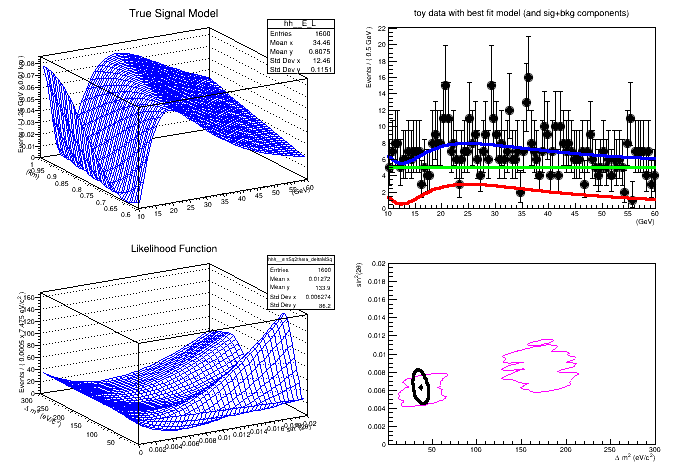

In [31]:
gROOT->GetListOfCanvases()->Draw()